In the example we will train a polynomial neural network to cancel echo from a signal.
> sample data as well as adaptive filtering technique can be taken from https://github.com/Wramberg/adaptfilt/blob/master/examples/echocancel.py

Let'generate a speech signal and recieved one with echo

In [3]:
import numpy as np
u = np.load('data/speech.npy')

coeffs = np.concatenate(([0.8], np.zeros(8), [-0.7], np.zeros(9),
                         [0.5], np.zeros(11), [-0.3], np.zeros(3),
                         [0.1], np.zeros(20), [-0.05]))    

d = np.convolve(u, coeffs) # add echo

# Add background noise just for example
v = np.random.randn(len(d)) * np.sqrt(5000)
d += v

As a baseline for comparison our neural network based filter one can use adaptive filtering

In [6]:
import adaptfilt as adf
M = 100  # Number of filter taps in adaptive filter
step = 0.1  # Step size
y_ad, e_ad, w_ad = adf.nlms(u, d, M, step, returnCoeffs=True)
# here y_ad is estimated signal d, e_ad is error, w_ad is weights at each step 

Now we will define a simple polynomial neural network architecture

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer

def createLieNet(inputDim=2, outputDim=2, order=2):
    model = Sequential()
    model.add(LieLayer(output_dim = outputDim, order=order,
                      input_shape = (inputDim,)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


For training we need some preprocessing of our data. One can implement filter taps consideration simply as rolling window procedure

In [12]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


u_rolling = rolling_window(u, M) # M is number of filter taps in adaptive filter
d_output = d[M-1:]
d_output = d_output[:u_rolling.shape[0]].reshape((-1,1))

Now we can create and fit our neural network

In [14]:
nnet = createLieNet(u_rolling.shape[1], 1, order=1)

nnet.fit(u_rolling, d_output, nb_epoch=1, verbose=1)

y_nn = nnet.predict(u_rolling).ravel()
e_nn = d_output.ravel() - y_nn
w_nn = nnet.get_weights()

Epoch 1/1
100210/100210 [==============================] - 4s - loss: 1498592.0444     


Let's calculate mean absolute error of filters


In [19]:
print('MAE for adaptive filter (nlms): ', np.abs(e_ad).mean())
print('MAE for polynomial neural network: ', np.abs(e_nn).mean())

('MAE for adaptive filter (nlms): ', 83.580587631400661)
('MAE for polynomial neural network: ', 257.35553116457976)


and draw some plots

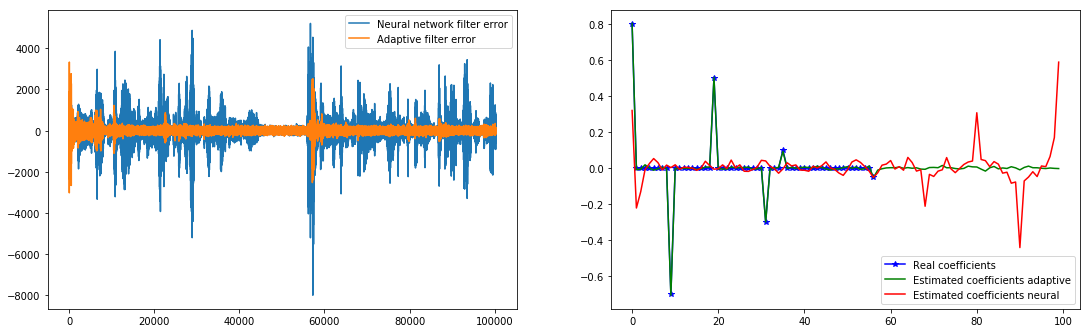

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax[0].plot(e_nn, label='Neural network filter error')
ax[0].plot(e_ad, label='Adaptive filter error')
ax[0].legend()

ax[1].plot(coeffs, 'b*-', label='Real coefficients')
ax[1].plot(w_ad[-1], 'g', label='Estimated coefficients adaptive')
ax[1].plot(w_nn[-1], 'r', label='Estimated coefficients neural')

plt.legend()
plt.show()

As one can see, nlms algorithm provides better results. Let's try to train neural network more time. The error decreases, but fitting requires more time.

In [41]:
nnet.fit(u_rolling, d_output, nb_epoch=5, verbose=1)

y_nn = nnet.predict(u_rolling).ravel()
e_nn = d_output.ravel() - y_nn
w_nn = nnet.get_weights()

print('MAE for adaptive filter (nlms): ', np.abs(e_ad).mean())
print('MAE for polynomial neural network: ', np.abs(e_nn).mean())

Epoch 1/5
100210/100210 [==============================] - 4s - loss: 9655.8715     
Epoch 2/5
100210/100210 [==============================] - 5s - loss: 8976.6752     
Epoch 3/5
100210/100210 [==============================] - 5s - loss: 9209.3626     
Epoch 4/5
100210/100210 [==============================] - 4s - loss: 8891.1427     
Epoch 5/5
100210/100210 [==============================] - 5s - loss: 9222.2173     
('MAE for adaptive filter (nlms): ', 83.580587631400661)
('MAE for polynomial neural network: ', 66.010199875622803)
